<div style="background-color: #E6F3FF; padding: 15px; border-radius: 10px; text-align: center;">
    <h1 style="color: #1A5276; font-family: Arial; font-size: 28px;"><b>🚀 پیش‌بینی درآمد فیلم‌ها با استفاده از رگرسیون خطی 🎬</b></h1>
    <h3 style="color: #34495E; font-family: Arial;">تحلیل داده‌های TMDB 5000 برای پیش‌بینی موفقیت مالی فیلم‌ها</h3>
    <hr style="border: 1px solid #1A5276;">
</div>

<div style="background-color: #F0F4F8; padding: 20px; border-radius: 12px; border: 2px solid #1A5276; text-align: center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <p style="color: #34495E; font-family: 'Arial', sans-serif; font-size: 16px; line-height: 1.6; margin: 0 auto; max-width: 80%;">
        این پروژه یه مدل رگرسیون خطی برای پیش‌بینی درآمد فیلم‌ها بر اساس داده‌های TMDB 5000 ساخته. هدف اینه که بتونیم با استفاده از ویژگی‌هایی مثل بودجه فیلم، محبوبیت، ژانر، بازیگرهای معروف، کارگردان و ماه اکران، پیش‌بینی کنیم یه فیلم چقدر فروش می‌کنه. این مدل می‌تونه به تهیه‌کننده‌های فیلم کمک کنه تا تصمیم‌های بهتری برای تولید فیلم بگیرن.
    </p>
    <hr style="border: 1px solid #1A5276; margin: 15px auto; width: 50%;">
</div>

/tmp/ipykernel_603/2266811366.py:86: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_603/2266811366.py:86: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_603/2266811366.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ehsanelyasi/anaconda3/envs/test1/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ehsanelyasi/anaconda3/envs/test1/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ehsanelyasi/anaconda3/envs/test1/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(

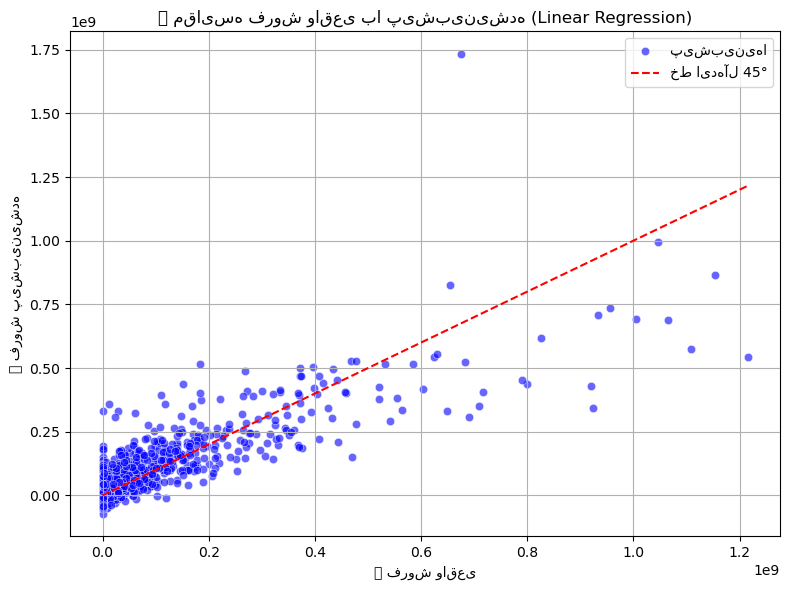

📋 معیارهای ارزیابی مدل:
MAE (میانگین خطای مطلق): $50,844,511
MSE (میانگین مربع خطا): $8,043,479,931,817,434
RMSE (ریشه میانگین مربع خطا): $89,685,450
R² (ضریب تعیین): 0.6912


In [65]:
#  Import Libraries
import pandas as pd #داده‌ها
import numpy as np
import json
from collections import defaultdict
from sklearn.linear_model import LinearRegression #ساخت مدل رگرسیون خطی
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt #نمودار
import seaborn as sns #نمودار

# Load Data
movies = pd.read_csv('tmdb_5000_movies.csv') #change to pandas file
credits = pd.read_csv('tmdb_5000_credits.csv')
df = movies.merge(credits, left_on='id', right_on='movie_id') #concted and in new file df

#  Extract Main Cast
def get_top_cast(cast_json, top_n=3):
    try:
        cast = json.loads(cast_json) #list
        return [actor['name'] for actor in cast[:top_n]]
    except:
        return []

df['main_cast'] = df['cast'].apply(lambda x: get_top_cast(x)) #new arrow neamed main cast with evrt movies

#  Identify Star Actors  3    100m
actor_revenue = defaultdict(list)
for _, row in df.iterrows():
    for actor in row['main_cast']:
        actor_revenue[actor].append(row['revenue'])

star_actors = {actor for actor, revenues in actor_revenue.items()
               if len(revenues) >= 3 and np.mean(revenues) > 100_000_000}

df['has_star'] = df['main_cast'].apply(lambda actors: int(any(actor in star_actors for actor in actors)))

#  Extract Director
def get_director(crew_json):
    try:
        crew = json.loads(crew_json)
        for member in crew:
            if member['job'] == 'Director':
                return member['name']
    except:
        return None

df['director'] = df['crew'].apply(get_director)

#  Top Directors 100m
director_revenue = df.groupby('director')['revenue'].mean()
top_directors = set(director_revenue[director_revenue > 100_000_000].index)
df['has_top_director'] = df['director'].apply(lambda x: int(x in top_directors))

# Genre Processing dom 0 1
df['genres'] = df['genres'].apply(json.loads)
df['genre_names'] = df['genres'].apply(lambda x: [g['name'] for g in x])
genre_dummies = df['genre_names'].explode().str.get_dummies().groupby(level=0).sum()
df = pd.concat([df, genre_dummies], axis=1)

#  Extract Release Month
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month'] = df['release_date'].dt.month.fillna(0).astype(int)

#  Train Linear Regression Model 80 20
features = pd.concat([
    df[['budget', 'popularity', 'release_month', 'has_star', 'has_top_director']],
    genre_dummies
], axis=1)

target = df['revenue']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

#  Evaluation Plot with 45-degree line
y_pred = model.predict(X_test)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue', label='پیش‌بینی‌ها')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='خط ایده‌آل 45°')
plt.xlabel("📌 فروش واقعی")
plt.ylabel("🔮 فروش پیش‌بینی‌شده")
plt.title("📊 مقایسه فروش واقعی با پیش‌بینی‌شده (Linear Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📋 معیارهای ارزیابی مدل:")
print(f"MAE (میانگین خطای مطلق): ${mae:,.0f}") # به طور متوسط پیش‌بینی‌هامون چقدر از واقعیت فاصله دارن
print(f"MSE (میانگین مربع خطا): ${mse:,.0f}") #میانگین مربع خطاها رو نشون می‌ده
print(f"RMSE (ریشه میانگین مربع خطا): ${rmse:,.0f}")
print(f"R² (ضریب تعیین): {r2:.4f}")

#  Prediction Function
def predict_movie_revenue(budget, popularity, release_month, genres_list, cast_list, director_name, 
                          model, star_actors, top_directors, genre_columns):
    input_data = {
        'budget': budget,
        'popularity': popularity,
        'release_month': release_month,
        'has_star': int(any(actor in star_actors for actor in cast_list)),
        'has_top_director': int(director_name in top_directors)
    }

    for genre in genre_columns:
        input_data[genre] = int(genre in genres_list)

    input_df = pd.DataFrame([input_data])
    return model.predict(input_df)[0]


In [66]:
# ✅ Test Example: Inception
pred = predict_movie_revenue(
    budget=160_000_000,
    popularity=150,
    release_month=7,
    genres_list=['Action', 'Science Fiction', 'Adventure'],
    cast_list=['Leonardo DiCaprio', 'Joseph Gordon-Levitt', 'Elliot Page'],
    director_name='Christopher Nolan',
    model=model,
    star_actors=star_actors,
    top_directors=top_directors,
    genre_columns=genre_dummies.columns
)
print(f"\n💰 پیش‌بینی فروش Inception: ${pred:,.0f}")


💰 پیش‌بینی فروش Inception: $611,383,984


/tmp/ipykernel_603/4259387092.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


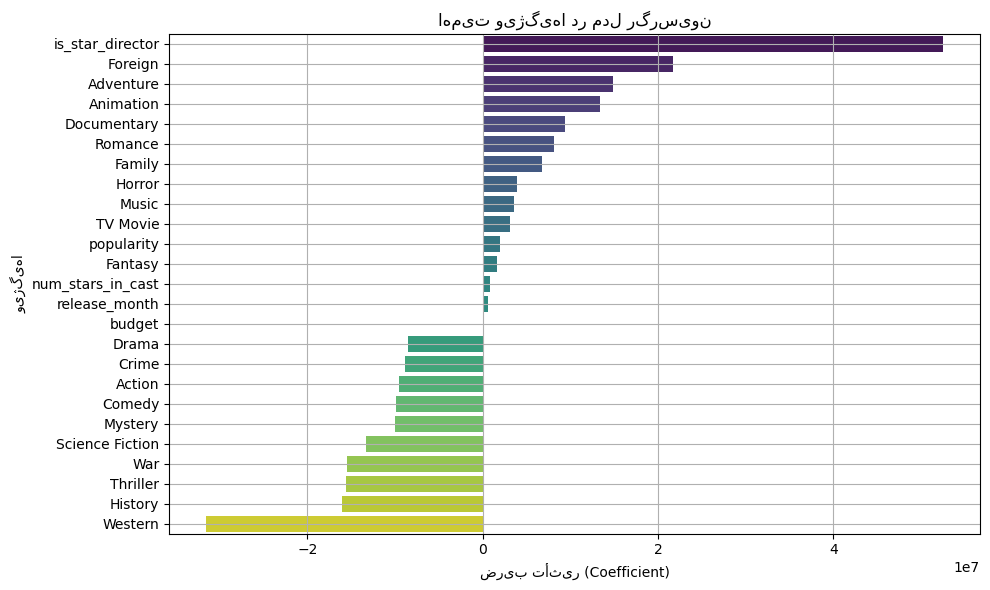

In [67]:
importances = model.coef_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("اهمیت ویژگی‌ها در مدل رگرسیون")
plt.xlabel("ضریب تأثیر (Coefficient)")
plt.ylabel("ویژگی‌ها")
plt.grid(True)
plt.tight_layout()
plt.show()


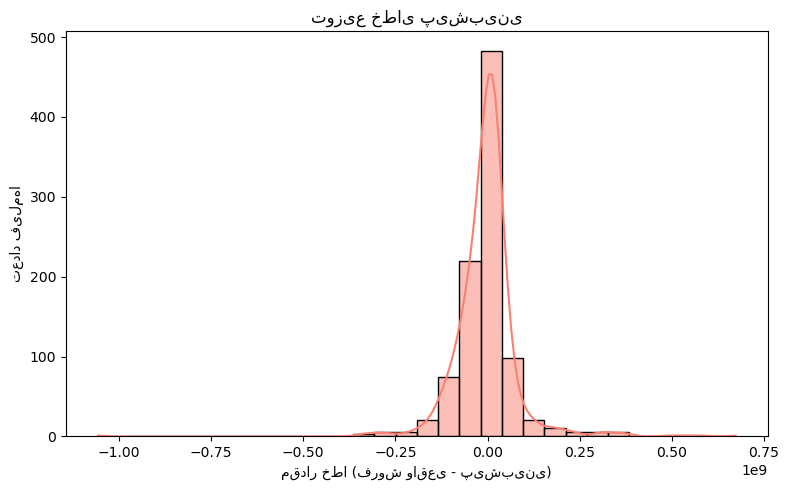

In [68]:
errors = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True, color='salmon')
plt.title("توزیع خطای پیش‌بینی")
plt.xlabel("مقدار خطا (فروش واقعی - پیش‌بینی)")
plt.ylabel("تعداد فیلم‌ها")
plt.tight_layout()
plt.show()
